# Feature selection

In [1]:
import pandas as pd
import numpy as np
import torch
import os
os.chdir('/home/jiageng/Documents/fhr/pipeline/')
import snf
from sklearn.feature_selection import *

In [2]:
fhr_data = pd.read_csv('../annotations/fhr-annotations.tsv',sep='\t').set_index('PUBLIC_ID').query('risk != -1')
fhr_data['risk'] += 1

In [3]:
# subset to samples with fhr labels
data = pd.read_csv('../matrices/gene_mut_matrix.tsv.gz',sep='\t').set_index('PUBLIC_ID').drop(columns=['SAMPLE'])

In [35]:
ensgid = pd.read_csv('../annotations/ensgid-autosomal-proteincoding.txt',sep='\t').set_index('Gene stable ID')

In [4]:
public_ids = list(set(fhr_data.index).intersection(set(data.index)))
print(len(public_ids))

867


In [5]:
def stdNormalize(df):
    numeric_df = df.select_dtypes(include=[np.number])
    std = numeric_df.std().fillna(1)
    mean = numeric_df - numeric_df.mean()
    numeric_df_norm = mean / std
    nonnumeric_df = df.select_dtypes(exclude=[np.number])
    df_norm = pd.concat([nonnumeric_df, numeric_df_norm], axis=1)
    return df_norm

In [12]:
X = data.loc[public_ids]
y = fhr_data.loc[public_ids,'risk']

In [30]:
print(X.shape)

(867, 14301)


Calculate metrics for feature selection

In [64]:
mifo = mutual_info_classif(X, y)

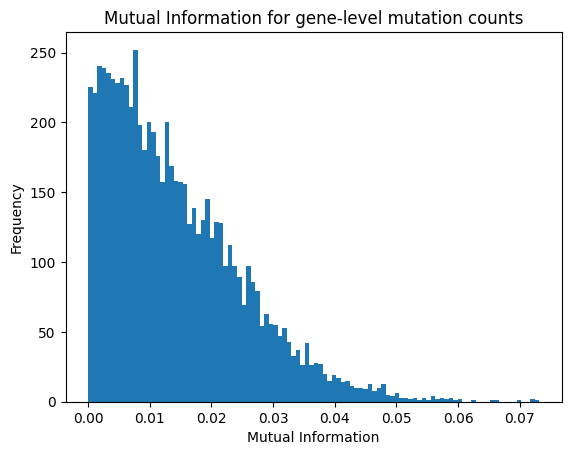

In [66]:
import matplotlib.pyplot as plt

plt.hist(mifo[mifo>0], bins=100)
plt.title('Mutual Information for gene-level mutation counts')
plt.xlabel('Mutual Information')
plt.ylabel('Frequency')
# plt.show()
plt.savefig('../assets/mutual_info_mut.png')

In [13]:
chi2_results = chi2(X, y)

In [28]:
chi2_results[1][chi2_results[1] == chi2_results[1]].min()

np.float64(7.705571726527808e-20)

In [29]:
varthresh = VarianceThreshold(0)
varthresh.fit(data)
len(varthresh.get_feature_names_out())

14301

In [31]:
varthresh.variances_

array([0.0162205 , 0.00102564, 0.00204917, ..., 0.0030706 , 0.0030706 ,
       0.00204917], shape=(14301,))

Family wise error rate significance threshold of 0.05

In [32]:
fwe = SelectFwe(chi2, alpha=0.05)
fwe.fit(X, y)
sum(fwe.get_support())

np.int64(11)

In [36]:
ensgid.loc[fwe.get_feature_names_out()]

,Gene name,Chromosome/scaffold name,Gene start (bp),Gene end (bp)
Gene stable ID,,,,
ENSG00000204414,CSHL1,17,63909597,63911341
ENSG00000183921,SDR42E2,16,22162492,22192208
ENSG00000167984,NLRC3,16,3539033,3577403
ENSG00000095970,TREM2,6,41158506,41163186
ENSG00000104415,CCN4,8,133191039,133231690
ENSG00000129353,SLC44A2,19,10602457,10644557
ENSG00000006210,CX3CL1,16,57372477,57385044
ENSG00000068078,FGFR3,4,1793293,1808872
ENSG00000178573,MAF,16,79585843,79600737


In [33]:
Xfwe = fwe.fit_transform(X, y)
print(Xfwe.shape)

(867, 11)


False discovery rate significance threshold of 0.05

In [37]:
fdr = SelectFdr(chi2, alpha=0.05)
fdr.fit(X, y)
sum(fdr.get_support())

np.int64(11)

In [47]:
X[fdr.get_feature_names_out()].sum()

ENSG00000204414     5
ENSG00000183921     3
ENSG00000167984    10
ENSG00000095970     3
ENSG00000104415     3
ENSG00000129353     8
ENSG00000006210     3
ENSG00000068078    43
ENSG00000178573    21
ENSG00000185372     3
ENSG00000141510    53
dtype: int64

In [38]:
ensgid.loc[fdr.get_feature_names_out()]

,Gene name,Chromosome/scaffold name,Gene start (bp),Gene end (bp)
Gene stable ID,,,,
ENSG00000204414,CSHL1,17,63909597,63911341
ENSG00000183921,SDR42E2,16,22162492,22192208
ENSG00000167984,NLRC3,16,3539033,3577403
ENSG00000095970,TREM2,6,41158506,41163186
ENSG00000104415,CCN4,8,133191039,133231690
ENSG00000129353,SLC44A2,19,10602457,10644557
ENSG00000006210,CX3CL1,16,57372477,57385044
ENSG00000068078,FGFR3,4,1793293,1808872
ENSG00000178573,MAF,16,79585843,79600737


False positive rate test significance threshold of 0.05

In [39]:
fpr = SelectFpr(chi2, alpha=0.05)
fpr.fit(X, y)
sum(fpr.get_support())

np.int64(901)

In [60]:
mut_scores = pd.DataFrame({'gid':data.columns, 
                           'freq': data.sum(axis=0).values,
                          'variance':varthresh.variances_,
                          'mutual_info':mifo, 
                          'chi2_x': chi2_results[0],
                          'chi2_p': chi2_results[1],
                          'fwe_alpha_5e2':fwe.get_support(),
                          'fdr_alpha_5e2':fdr.get_support(),
                          'fpr_alpha_5e2':fpr.get_support(),
                         })
mut_scores.to_csv('../scores/gene_mut_scores.tsv',sep='\t',index=False)

# Pick desired genes

In [92]:
desired_gid = [gid for gid in fdr.get_feature_names_out() if gid != "ENSG00000141510"]
print(len(desired_gid))
data[desired_gid].to_csv('../matrices/gene_mut_matrix_fdr5e2.tsv',sep='\t')

10


In [ ]:
desired_gid = mut_scores.query('freq>=10 and chi2_p < 0.05').gid 
print(len(desired_gid))

86


In [81]:
data[desired_gid].to_csv('../matrices/gene_mut_matrix_gt10_p5e2.tsv',sep='\t')

Remove TP53 as a predictor because it is used to define GHR and FHR labels

In [ ]:
desired_gid = mut_scores.query('freq>=10 and chi2_p < 0.05 and gid != "ENSG00000141510"').gid # remove TP53
print(len(desired_gid))

85


In [ ]:
data[desired_gid].to_csv('../matrices/gene_mut_matrix_gt10_p5e2_noTP53.tsv',sep='\t')